# Color Pre-processing

Dataset used: https://www.kaggle.com/datasets/mostafaabla/garbage-classification




## Download dependencies

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
import cv2
import glob
import zipfile

from google.colab import drive
from PIL import Image
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## Mount google drive

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/garbage_classification"

# Print the folder structure for debugging
print("Contents of the dataset directory:")
for root, dirs, files in os.walk(base_path):
    print(f"Root: {root}, Subdirectories: {dirs}, Files: {len(files)} files")

Contents of the dataset directory:
Root: /content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/garbage_classification, Subdirectories: ['metal', 'plastic', 'clothes', 'paper', 'cardboard', 'white-glass', 'brown-glass', 'shoes', 'green-glass', 'trash', 'battery', 'biological'], Files: 0 files
Root: /content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/garbage_classification/metal, Subdirectories: [], Files: 769 files
Root: /content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/garbage_classification/plastic, Subdirectories: [], Files: 865 files
Root: /content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/garbage_classification/clothes, Subdirectories: [], Files: 5345 files
Root: /content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/garbage_classification/paper, Subdirectories: [], Files: 1050 files
Root: /content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/garbage_classification/ca

## Create dataframe
- with the columns: image path, label

In [6]:
# Map the original classes to new categories
recycling_groups = {
    'battery': 'Hazardous Waste',
    'biological': 'Organic Waste',
    'brown-glass': 'Glass',
    'green-glass': 'Glass',
    'white-glass': 'Glass',
    'cardboard': 'Paper & Cardboard',
    'paper': 'Paper & Cardboard',
    'clothes': 'Textiles',
    'shoes': 'Textiles',
    'metal': 'Metal',
    'plastic': 'Plastic',
    'trash': 'Trash'
}

# Initialize an empty list to hold image paths and labels
data = []

# Ensure the path exists
if os.path.exists(base_path):
    # Traverse through the dataset directory
    for original_class in os.listdir(base_path):
        class_path = os.path.join(base_path, original_class)

        if os.path.isdir(class_path):  # Check if it's a folder
            # Map the original class to the appropriate recycling group
            new_label = recycling_groups.get(original_class, original_class)

            # Loop through all images in the class folder
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                if image_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):  # Check for image extensions
                    # Append the image path and label to the list
                    data.append([image_path, new_label])

    # Create a DataFrame from the list
    df = pd.DataFrame(data, columns=['image_path', 'label'])

    # Show the first few rows of the DataFrame
    print("Dataset successfully created!\n")
    print(df.head())

else:
    print("Dataset directory not found, please check the uploaded folder structure.")

Dataset successfully created!

                                          image_path  label
0  /content/drive/My Drive/50.021 Artificial Inte...  Metal
1  /content/drive/My Drive/50.021 Artificial Inte...  Metal
2  /content/drive/My Drive/50.021 Artificial Inte...  Metal
3  /content/drive/My Drive/50.021 Artificial Inte...  Metal
4  /content/drive/My Drive/50.021 Artificial Inte...  Metal


In [7]:
print(f"Initial dataset size: {len(df)}")

Initial dataset size: 15535


In [8]:
# save df to csv
df.to_csv("/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/original_metadata.csv", index=False)

## Remove Duplicated Files

In [9]:
# Remove duplicate image paths
df = df.drop_duplicates(subset=['image_path']).reset_index(drop=True)
print(f"Dataset size after removing duplicates: {len(df)} images")

print("Final dataset sample:\n", df.head())

Dataset size after removing duplicates: 15535 images
Final dataset sample:
                                           image_path  label
0  /content/drive/My Drive/50.021 Artificial Inte...  Metal
1  /content/drive/My Drive/50.021 Artificial Inte...  Metal
2  /content/drive/My Drive/50.021 Artificial Inte...  Metal
3  /content/drive/My Drive/50.021 Artificial Inte...  Metal
4  /content/drive/My Drive/50.021 Artificial Inte...  Metal


## Visualise number of images grouped by recycling categories

<ipython-input-10-5b25617fe1bf>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


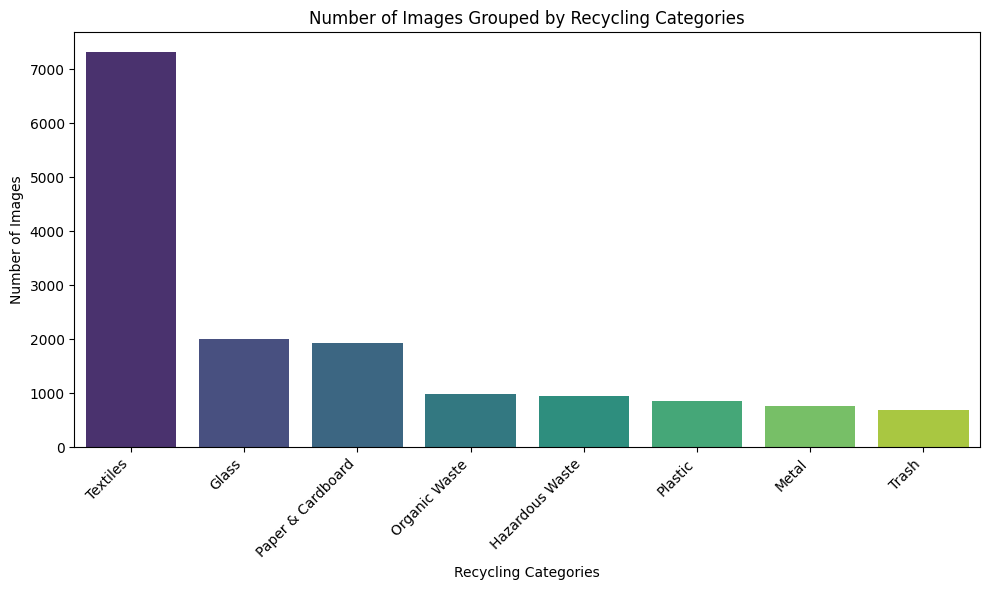

In [10]:
# Group the DataFrame by label and count the number of images per label
label_counts = df['label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels for better visibility
plt.xlabel('Recycling Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images Grouped by Recycling Categories')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

## Data Resampling

### Undersample clothes and shoes to 1000 samples each

<ipython-input-11-78df6d87c593>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


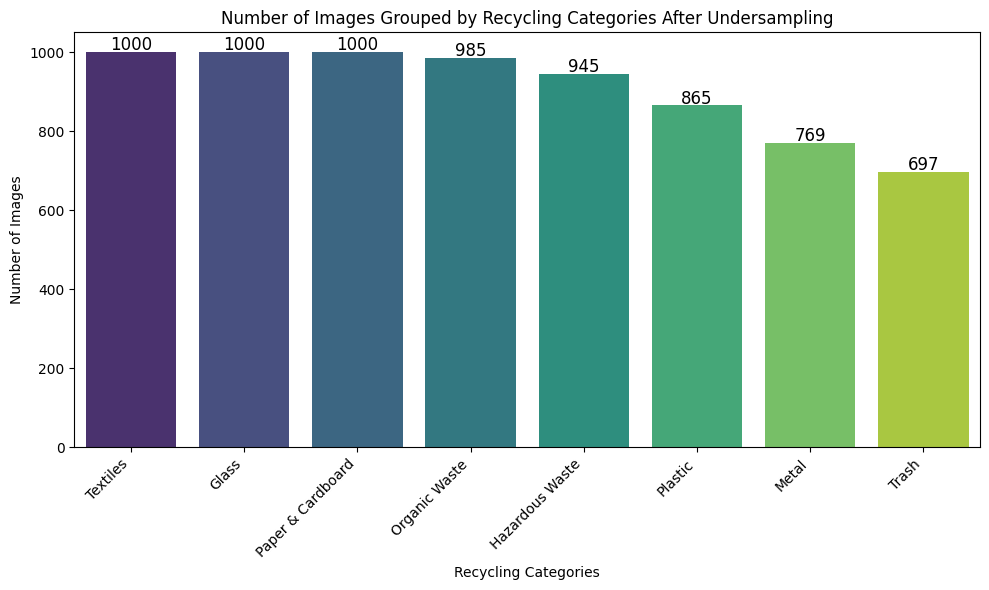

In [11]:
# Undersample the 'Textiles', 'Glass', 'Paper & Cardboard' classes to 1000 samples
undersample_limit = 1000

# List of categories to undersample
undersample_categories = ['Textiles', 'Glass', 'Paper & Cardboard']

# Initialize an empty list for the undersampled data
df_undersampled = pd.DataFrame(columns=df.columns)

# Undersample each category to the specified limit
for category in undersample_categories:
    # Get the rows for the current category
    category_data = df[df['label'] == category]

    # Check if there are more samples than the limit
    if len(category_data) > undersample_limit:
        # Randomly sample the data to the specified limit
        category_data = category_data.sample(undersample_limit, random_state=42)

    # Append the undersampled category data to the final dataframe
    df_undersampled = pd.concat([df_undersampled, category_data], ignore_index=True)

# Add the rest of the categories without undersampling
other_categories = df[~df['label'].isin(undersample_categories)]
df_undersampled = pd.concat([df_undersampled, other_categories], ignore_index=True)

# Count the number of images per label
label_counts = df_undersampled['label'].value_counts()

# Plot the bar chart using sns.barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels for better visibility
plt.xlabel('Recycling Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images Grouped by Recycling Categories After Undersampling')
plt.tight_layout()  # Adjust layout to fit labels

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

In [12]:
df_undersampled

,image_path,label
0,/content/drive/My Drive/50.021 Artificial Inte...,Textiles
1,/content/drive/My Drive/50.021 Artificial Inte...,Textiles
2,/content/drive/My Drive/50.021 Artificial Inte...,Textiles
3,/content/drive/My Drive/50.021 Artificial Inte...,Textiles
4,/content/drive/My Drive/50.021 Artificial Inte...,Textiles
...,...,...
7256,/content/drive/My Drive/50.021 Artificial Inte...,Organic Waste
7257,/content/drive/My Drive/50.021 Artificial Inte...,Organic Waste
7258,/content/drive/My Drive/50.021 Artificial Inte...,Organic Waste
7259,/content/drive/My Drive/50.021 Artificial Inte...,Organic Waste


## Data Pre-processing
- keeps RGB

In [35]:
# Directory for saving the preprocessed images
save_dir = "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images"
os.makedirs(save_dir, exist_ok=True)

In [36]:
import os
import cv2
import numpy as np
from PIL import Image
import random

# Function to process and save the image with better preprocessing
def process_and_save_image(image_path, save_path):
    try:
        # Open image using PIL and convert to RGB
        image = Image.open(image_path).convert('RGB')

        # Convert to numpy array for processing
        img_array = np.array(image)

        # Resize the image
        img_resized = cv2.resize(img_array, target_size)

        # Basic color correction and normalization
        # Instead of just normalizing, let's use a simpler approach

        # Apply a slight Gaussian blur to reduce noise
        img_blur = cv2.GaussianBlur(img_resized, (3, 3), 0)

        # Simple color enhancement
        lab = cv2.cvtColor(img_blur, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE with milder settings
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)

        # Merge channels back
        enhanced_lab = cv2.merge((cl, a, b))
        enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

        # Ensure proper brightness - check and adjust if too dark
        hsv = cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)

        # Calculate average brightness
        avg_brightness = np.mean(v)

        # If too dark, increase brightness
        if avg_brightness < 100:  # Threshold for "too dark"
            # Increase value channel
            gain = min(255 / (avg_brightness + 1), 2.0)  # Limit the gain to avoid over-brightening
            v = np.clip(v * gain, 0, 255).astype(np.uint8)

            # Merge back
            adjusted_hsv = cv2.merge([h, s, v])
            enhanced_rgb = cv2.cvtColor(adjusted_hsv, cv2.COLOR_HSV2RGB)

        # Save the processed image
        cv2.imwrite(save_path, cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2BGR))

        return enhanced_rgb

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        # Return original image in case of error
        return img_array

# Function to apply data augmentation for training set
def apply_augmentation(image):
    """Apply random augmentations to increase dataset variability"""
    augmented = image.copy()

    # Random horizontal flip with 50% probability
    if random.random() > 0.5:
        augmented = cv2.flip(augmented, 1)

    # Random slight rotation (+/- 15 degrees)
    if random.random() > 0.5:
        angle = random.uniform(-15, 15)
        h, w = augmented.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        augmented = cv2.warpAffine(augmented, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # Random slight brightness/contrast adjustment (milder)
    if random.random() > 0.5:
        alpha = random.uniform(0.9, 1.1)  # Contrast control (reduced range)
        beta = random.uniform(-5, 10)     # Brightness control (bias toward brightening)
        augmented = cv2.convertScaleAbs(augmented, alpha=alpha, beta=beta)

    return augmented

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import random
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

target_size = (224, 224)

df_original = df_undersampled

# Step 2: Train-test-validation split on ORIGINAL data
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

train_data = []
test_data = []
val_data = []

# Group by label and perform stratified split
for label, group in df_original.groupby('label'):
    # Shuffle the data within the group
    group = group.sample(frac=1, random_state=42).reset_index(drop=True)

    # Perform stratified train-test-validation split
    train, test_val = train_test_split(group, test_size=(test_ratio + val_ratio), random_state=42, stratify=group['label'])
    test, val = train_test_split(test_val, test_size=(val_ratio / (test_ratio + val_ratio)), random_state=42, stratify=test_val['label'])

    # Append the split data to respective lists
    train_data.append(train)
    test_data.append(test)
    val_data.append(val)

# Concatenate all splits
df_train = pd.concat(train_data, ignore_index=True)
df_test = pd.concat(test_data, ignore_index=True)
df_val = pd.concat(val_data, ignore_index=True)

# Step 3: Create separate output directories
train_output_dir = "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images/train"
val_output_dir = "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images/val"
test_output_dir = "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images/test"

os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(val_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# Step 4: Process training images WITH augmentation
for index, row in df_train.iterrows():
    image_path = row['image_path']
    label = row['label']
    save_path = os.path.join(train_output_dir, f"{label}_{index}_processed.jpeg")

    # Process and save the image
    processed_img = process_and_save_image(image_path, save_path)

    # Apply augmentation only to training data
    for aug_idx in range(random.randint(1, 2)):  # Create 1-2 augmented versions
        aug_save_path = os.path.join(train_output_dir, f"{label}_{index}_aug{aug_idx}.jpeg")
        augmented_img = apply_augmentation(processed_img)
        cv2.imwrite(aug_save_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

In [38]:
# Step 5: Process validation and test images WITHOUT augmentation
for index, row in df_val.iterrows():
    save_path = os.path.join(val_output_dir, f"{row['label']}_{index}_processed.jpeg")
    process_and_save_image(row['image_path'], save_path)

for index, row in df_test.iterrows():
    save_path = os.path.join(test_output_dir, f"{row['label']}_{index}_processed.jpeg")
    process_and_save_image(row['image_path'], save_path)

# Step 6: Create final CSVs with the processed image paths
train_processed_paths = glob.glob(os.path.join(train_output_dir, "*.jpeg"))
val_processed_paths = glob.glob(os.path.join(val_output_dir, "*.jpeg"))
test_processed_paths = glob.glob(os.path.join(test_output_dir, "*.jpeg"))

In [39]:
df_train_processed = pd.DataFrame({
    'image_path': train_processed_paths,
    'label': [os.path.basename(path).split('_')[0] for path in train_processed_paths]
})

df_val_processed = pd.DataFrame({
    'image_path': val_processed_paths,
    'label': [os.path.basename(path).split('_')[0] for path in val_processed_paths]
})

df_test_processed = pd.DataFrame({
    'image_path': test_processed_paths,
    'label': [os.path.basename(path).split('_')[0] for path in test_processed_paths]
})


# Save the final CSVs
df_train_processed.to_csv("/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images/train.csv", index=False)
df_val_processed.to_csv("/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images/validation.csv", index=False)
df_test_processed.to_csv("/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images/test.csv", index=False)

print("Preprocessing and splitting complete!")

Preprocessing and splitting complete!


In [40]:
print("Train set size:", df_train_processed.shape[0])
print("Validation set size:", df_val_processed.shape[0])
print("Test set size:", df_test_processed.shape[0])

Train set size: 12670
Validation set size: 1091
Test set size: 1090
